In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
        Info Given PhasorNetworks was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? PhasorNetworks
[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage = -0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [8]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [9]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test ODE Layer

In [10]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [11]:
ps_phase2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
            layer_2 = ())

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = ())

In [12]:
p0, _ = to_phase(x, ps_phase2, st_phase)

([0.9621183521796359 0.14853194706872877 … 0.17156837979634934 0.2207192722515445; -0.7507570041684075 0.867429651787117 … -0.4410375489659723 -0.15208475266136406], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

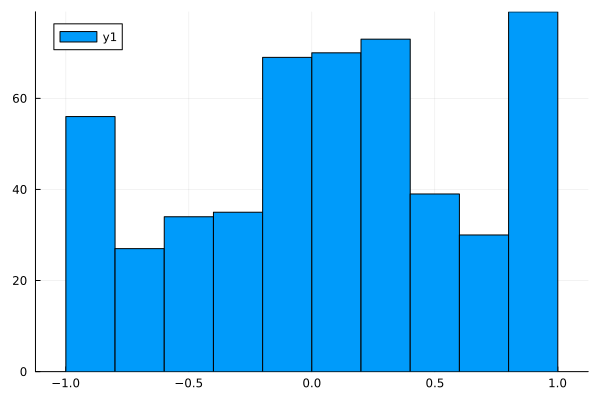

In [13]:
histogram(vec(p0))

In [14]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [15]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [16]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [17]:
using ChainRulesCore: ignore_derivatives

In [18]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, mod(t, spk_args.t_period), spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [19]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#26"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

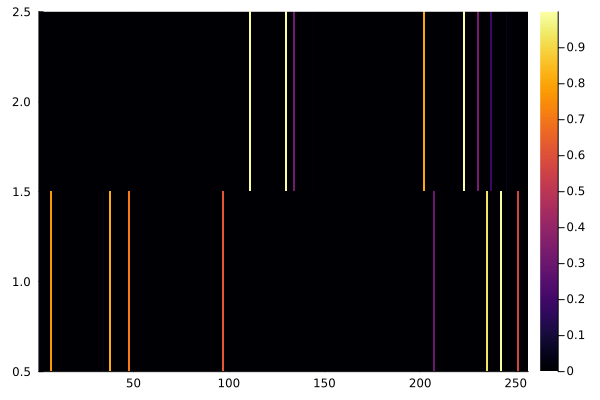

In [20]:
heatmap(xfn(1.4))

In [21]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [22]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt], dense=true))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#29),
    layer_3 = WrappedFunction(#30),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [23]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [24]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#149"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#26"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(

In [25]:
function potential_to_phase(potential::AbstractArray, ts::AbstractVector; offset::Real=0.0, spk_args::SpikingArgs)
    current_zeros = ones(ComplexF32, (length(ts)))

    ignore_derivatives() do
        #find the angle of a neuron representing 0 phase at the current moment in time
        current_zeros = phase_to_potential.(0.0, ts, offset=offset, spk_args=spk_args)
    end
    #get the arc subtended in the complex plane between that reference and our neuron potentials
    potential = permutedims(potential, (3,2,1))
    arc = angle.(current_zeros) .- angle.(potential) 
    arc = permutedims(arc, (3,2,1))

    #normalize by pi and shift to -1, 1
    phase = mod.((arc ./ pi .+ 1.0), 2.0) .- 1.0
end

potential_to_phase (generic function with 1 method)

In [56]:
function angular_mean(phases::AbstractArray; dims)
    u = exp.(pi * 1im .* phases)
    u_mean = mean(u, dims=dims)
    phase = angle.(u_mean) ./ pi
    return phase
end

angular_mean (generic function with 2 methods)

In [59]:
function mean_phase(solution::ODESolution, i_warmup::Int; spk_args::SpikingArgs, offset::Real=0.0)
    inds = solution.t .> (i_warmup * spk_args.t_period)

    u = Array(solution)[:,:,inds]
    t = solution.t[inds]
    phase = potential_to_phase(u, t, offset=offset, spk_args=spk_args)
    phase = angular_mean(phase, dims=(3))[:,:,1]

    return phase
end

mean_phase (generic function with 1 method)

In [60]:
p_sol = potential_to_phase(Array(y_sol), y_sol.t, offset=0.0, spk_args=spk_args)

128×256×1001 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0

In [61]:
mp = mean_phase(y_sol, 1, spk_args=spk_args, offset=0.0)

128×256 Matrix{Float64}:
 -0.980866    0.693825    -0.724934   …   0.919728     0.663018   0.852146
  0.578705   -0.174979    -0.517169      -0.184476    -0.865661  -0.188023
  0.477004   -0.225057    -0.433095      -0.146093    -0.747079  -0.172542
 -0.866185    0.713372    -0.818524       0.903334     0.569487   0.846141
 -0.400302    0.844859     0.470052       0.80066      0.10861    0.805646
  0.794376    0.577086    -0.621136   …  -0.970481     0.875217   0.891853
  0.465534   -0.228464    -0.420016      -0.14343     -0.734513  -0.171505
 -0.0333692  -0.317939     0.303803      -0.0701997   -0.292587  -0.144193
  0.432376   -0.237106    -0.376118      -0.136641    -0.699177  -0.168881
  0.667666   -0.00894057  -0.565778      -0.312333    -0.975553  -0.253577
  0.389788   -0.24633     -0.305337   …  -0.12934     -0.655884  -0.166086
  0.480089   -0.224096    -0.436447      -0.146843    -0.75049   -0.172834
  0.276679   -0.26555     -0.0609358     -0.113925    -0.550583  -0.160267


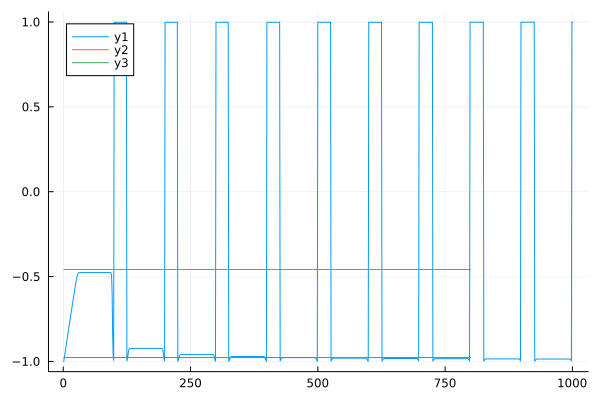

In [62]:
plot(p_sol[1,1,:])
plot!(mean(p_sol[1,1,201:end]) .* ones(1001-201))
plot!(median(p_sol[1,1,201:end]) .* ones(1001-201))

In [63]:
mp[1,1]

-0.9808659735520587

In [64]:
mean(mean_phase(sol_model(x, ps_sol, st_sol)[1], 1, offset=0.0, spk_args=spk_args))

0.0012993277165353383

In [65]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))

In [66]:
withgradient(p -> mean(mean_phase(sol_model(x, p, st_sol)[1], 1, offset=0.0, spk_args=spk_args)), psf_sol)

(val = 0.0012993277749260446, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.00041682454 -0.0014570102; -3.2402808f-5 0.00015625183; … ; 3.68778f-5 1.9236133f-5; -3.830477f-5 -3.9053186f-5], bias = Float32[0.020129725; -0.0064334366; … ; 0.0045710467; -0.004003318;;])),))

In [91]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args, final_t=false)[:,:,201:end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#98),
    layer_3 = WrappedFunction(#99),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction(#100),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [92]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.14064194 0.1227512; 0.060155258 0.07072492; … ; -0.013296644 -0.16892326; -0.16824064 0.054195236], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [93]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([0.9707334676198731 0.5505457708272883 … 0.70090203573727 0.917359773070997; 0.63195944760763 0.21315740788790363 … -0.9706789567450991 -0.6002573715235447], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [94]:
y_ode

2×256 Matrix{Float64}:
 0.970733  0.550546  -0.793129   0.821776  …  -0.962142   0.700902   0.91736
 0.631959  0.213157  -0.482039  -0.71549      -0.575119  -0.970679  -0.600257

In [95]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.14064194 0.1227512; 0.060155258 0.07072492; … ; -0.013296644 -0.16892326; -0.16824064 0.054195236], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [96]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

1.0075158114742044

In [97]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.007515815520204, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.008194601 0.009388951; -0.013752933 0.011697602; … ; -0.03139128 0.0024709268; 0.0012183518 0.0037821666], bias = Float32[1.0493844; -1.7168782; … ; 2.4532185; -0.59009594;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.0015297489 0.0018190107 … -0.0021703616 -0.0011320873; 0.022201438 0.022146938 … -0.020943116 -0.023806356], bias_real = Float32[-0.009548943, -0.03893631], bias_imag = Float32[-0.010435494, -0.015990295])),))

In [104]:
ps_ode2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
        layer_2 = ps_ode.layer_2,
        layer_3 = ps_ode.layer_3,
        layer_4 = ps_ode.layer_4,
        layer_5 = ps_ode.layer_5,
        layer_6 = ps_ode.layer_6)

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.14064194 0.1227512; 0.060155258 0.07072492; … ; -0.013296644 -0.16892326; -0.16824064 0.054195236], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [105]:
psf = ComponentArray(ps_ode2)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.14064194 0.1227512; 0.060155258 0.07072492; … ; -0.013296644 -0.16892326; -0.16824064 0.054195236], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [106]:
args.epochs = 5

5

In [107]:
losses, ps_train, st_train = train(ode_model, psf, st_ode, train_loader, args, verbose=true)

[ Info: Training on CPU


Epoch 1 loss: 1.1271665329672278
Epoch 1 loss: 0.9119799784389797
Epoch 1 loss: 0.8284318004393224
Epoch 1 loss: 0.697449423300555
Epoch 1 loss: 0.7203530180834422
Epoch 1 loss: 0.6046545825332253
Epoch 1 loss: 0.4972159660750306
Epoch 1 loss: 0.5713763037176504
Epoch 1 loss: 0.4669818899542216
Epoch 1 loss: 0.5033092309048472
Epoch 1 loss: 0.45932586099552214
Epoch 1 loss: 0.49541898183000127
Epoch 1 loss: 0.46328539331535556
Epoch 1 loss: 0.47919777548081716
Epoch 1 loss: 0.46625859585860835
Epoch 1 loss: 0.4825253228108736
Epoch 1 loss: 0.4586502533429686
Epoch 1 loss: 0.46353238823068893
Epoch 1 loss: 0.4428440462843526
Epoch 1 loss: 0.445930099804623
Epoch 1 loss: 0.4983887237106067
Epoch 1 loss: 0.491771981985524
Epoch 1 loss: 0.4725799503122424
Epoch 1 loss: 0.4486078586436413
Epoch 1 loss: 0.45262088775075665
Epoch 1 loss: 0.4484903091979593
Epoch 1 loss: 0.4445452866776221
Epoch 1 loss: 0.44875244049028606
Epoch 1 loss: 0.4473527109322835
Epoch 1 loss: 0.44471561745493393
Epoc

(Any[1.1271665329672278, 0.9119799784389797, 0.8284318004393224, 0.697449423300555, 0.7203530180834422, 0.6046545825332253, 0.4972159660750306, 0.5713763037176504, 0.4669818899542216, 0.5033092309048472  …  0.23737463698019898, 0.23414700827669888, 0.24022240659073799, 0.2485769229575639, 0.2275014635427203, 0.22324598468704732, 0.24087056227118864, 0.22928239713664353, 0.2505635514458763, 0.25276675792150294], (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.13155302 0.12170537; 0.035641164 0.07862482; … ; 0.006342309 -0.1915952; -0.16658613 0.06554862], bias = Float32[0.011581843; 0.0077858637; … ; -0.002487369; -0.0016566708;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.70394874 0.91917527 … 0.9582514 0.15316127; 0.031792007 0.0732181 … -1.6259269 0.29000703], bias_real = Float32[1.1910025, 1.1094097], bias_imag = Float32[-0.023676215, 0.009590168])), (l

In [113]:
losses2, ps_train2, st_train = train(ode_model, ps_train, st_ode, train_loader, args, verbose=true)

[ Info: Training on CPU


Epoch 1 loss: 0.24360568631588342
Epoch 1 loss: 0.33518260825318147
Epoch 1 loss: 0.22570198266288302
Epoch 1 loss: 0.28294718828146753
Epoch 1 loss: 0.2613882640232846
Epoch 1 loss: 0.2720261193792608
Epoch 1 loss: 0.25205406979574135
Epoch 1 loss: 0.25581163556247466
Epoch 1 loss: 0.2272485217401163
Epoch 1 loss: 0.2369948205978231
Epoch 1 loss: 0.24768169298749879
Epoch 1 loss: 0.2332685593295356
Epoch 1 loss: 0.2292886016429049
Epoch 1 loss: 0.2358755775785013
Epoch 1 loss: 0.2461884750498587
Epoch 1 loss: 0.23188948632017298
Epoch 1 loss: 0.26568255118023115
Epoch 1 loss: 0.2238045088138791
Epoch 1 loss: 0.25459126689759254
Epoch 1 loss: 0.2490926078330109
Epoch 1 loss: 0.2428562895719243
Epoch 1 loss: 0.2460921821409877
Epoch 1 loss: 0.23565681143203396
Epoch 1 loss: 0.22468039823370622
Epoch 1 loss: 0.2725846538107158
Epoch 1 loss: 0.23038399969760895
Epoch 1 loss: 0.2491278505597395
Epoch 1 loss: 0.232923945367073
Epoch 1 loss: 0.22739416153835942
Epoch 1 loss: 0.24190541863195

(Any[0.24360568631588342, 0.33518260825318147, 0.22570198266288302, 0.28294718828146753, 0.2613882640232846, 0.2720261193792608, 0.25205406979574135, 0.25581163556247466, 0.2272485217401163, 0.2369948205978231  …  0.23037437210957507, 0.22447561352632875, 0.22564093680031858, 0.22596490358812457, 0.2233259564804042, 0.20416347876289517, 0.22808150099004912, 0.21087923944185377, 0.23105812110322047, 0.22296775182757536], (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.13430238 0.11937024; 0.030642988 0.07954342; … ; 0.0097987605 -0.19558954; -0.1699818 0.06517649], bias = Float32[0.012929791; 0.010159055; … ; -0.0027088607; -0.001811613;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.71055377 0.9127311 … 0.9694068 0.1587985; 0.0337667 0.07481235 … -1.6168759 0.28873068], bias_real = Float32[1.2678181, 1.1625265], bias_imag = Float32[-0.027762303, 0.011643085]

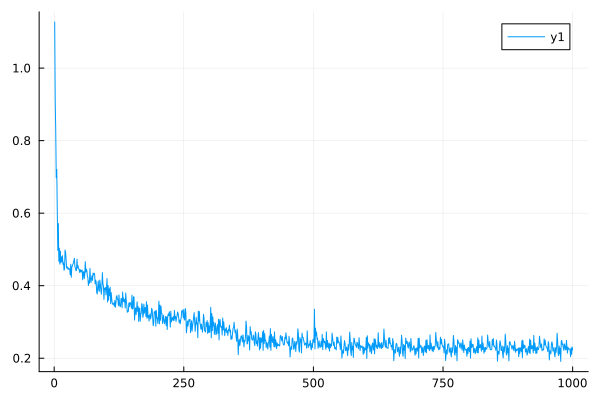

In [114]:
plot(vcat(losses, losses2))

In [115]:
ps_train2 .- psf

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.006339565 -0.0033809617; -0.02951227 0.0088185; … ; 0.023095405 -0.026666284; -0.001741156 0.010981251], bias = Float32[0.012929791; 0.010159055; … ; -0.0027088607; -0.001811613;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.06256169 -0.084614694 … 0.07518369 0.039349504; 0.005412692 0.0025604963 … 0.0039651394 0.01456669], bias_real = Float32[0.2678181, 0.16252649], bias_imag = Float32[-0.027762303, 0.011643085]))

In [116]:
loss_and_accuracy(test_loader, ode_model, ps_train2, st_train)

(0.22371740659519523, 0.71484375)

In [117]:
loss_and_accuracy(test_loader, ode_model, ps_train2, st_train)

(0.22371740659519523, 0.71484375)